In [1]:
import yfinance as yf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

plt.style.use('fivethirtyeight')

In [2]:
tickers = ['IBM', 'GOOG', 'AMZN', ]

In [3]:
end_date = datetime.today()
start_date = end_date - timedelta(days=365*2)
start_date

datetime.datetime(2021, 11, 19, 9, 39, 20, 394536)

In [4]:
close_df = pd.DataFrame()

In [5]:
for ticker in tickers:
    data= yf.download(ticker, start=start_date, end=end_date)
    close_df[ticker] = data['Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
close_df.head()

,IBM,GOOG,AMZN
Date,,,
2021-11-19,116.050003,149.952499,183.828506
2021-11-22,116.470001,147.078506,178.628494
2021-11-23,116.790001,146.757004,179.001999
2021-11-24,116.730003,146.717499,179.020493
2021-11-26,115.809998,142.806000,175.227997


In [7]:
returns = close_df.pct_change()
returns.head()

,IBM,GOOG,AMZN
Date,,,
2021-11-19,NaN,NaN,NaN
2021-11-22,0.003619,-0.019166,-0.028287
2021-11-23,0.002747,-0.002186,0.002091
2021-11-24,-0.000514,-0.000269,0.000103
2021-11-26,-0.007881,-0.026660,-0.021185


In [8]:
means = returns.mean()
means

IBM     0.000636
GOOG    0.000061
AMZN   -0.000110
dtype: float64

In [9]:
variances = returns.var()
variances

IBM     0.000171
GOOG    0.000485
AMZN    0.000724
dtype: float64

In [10]:
cov_matrix = returns.cov()
cov_matrix

,IBM,GOOG,AMZN
IBM,0.000171,0.000085,0.000090
GOOG,0.000085,0.000485,0.000409
AMZN,0.000090,0.000409,0.000724


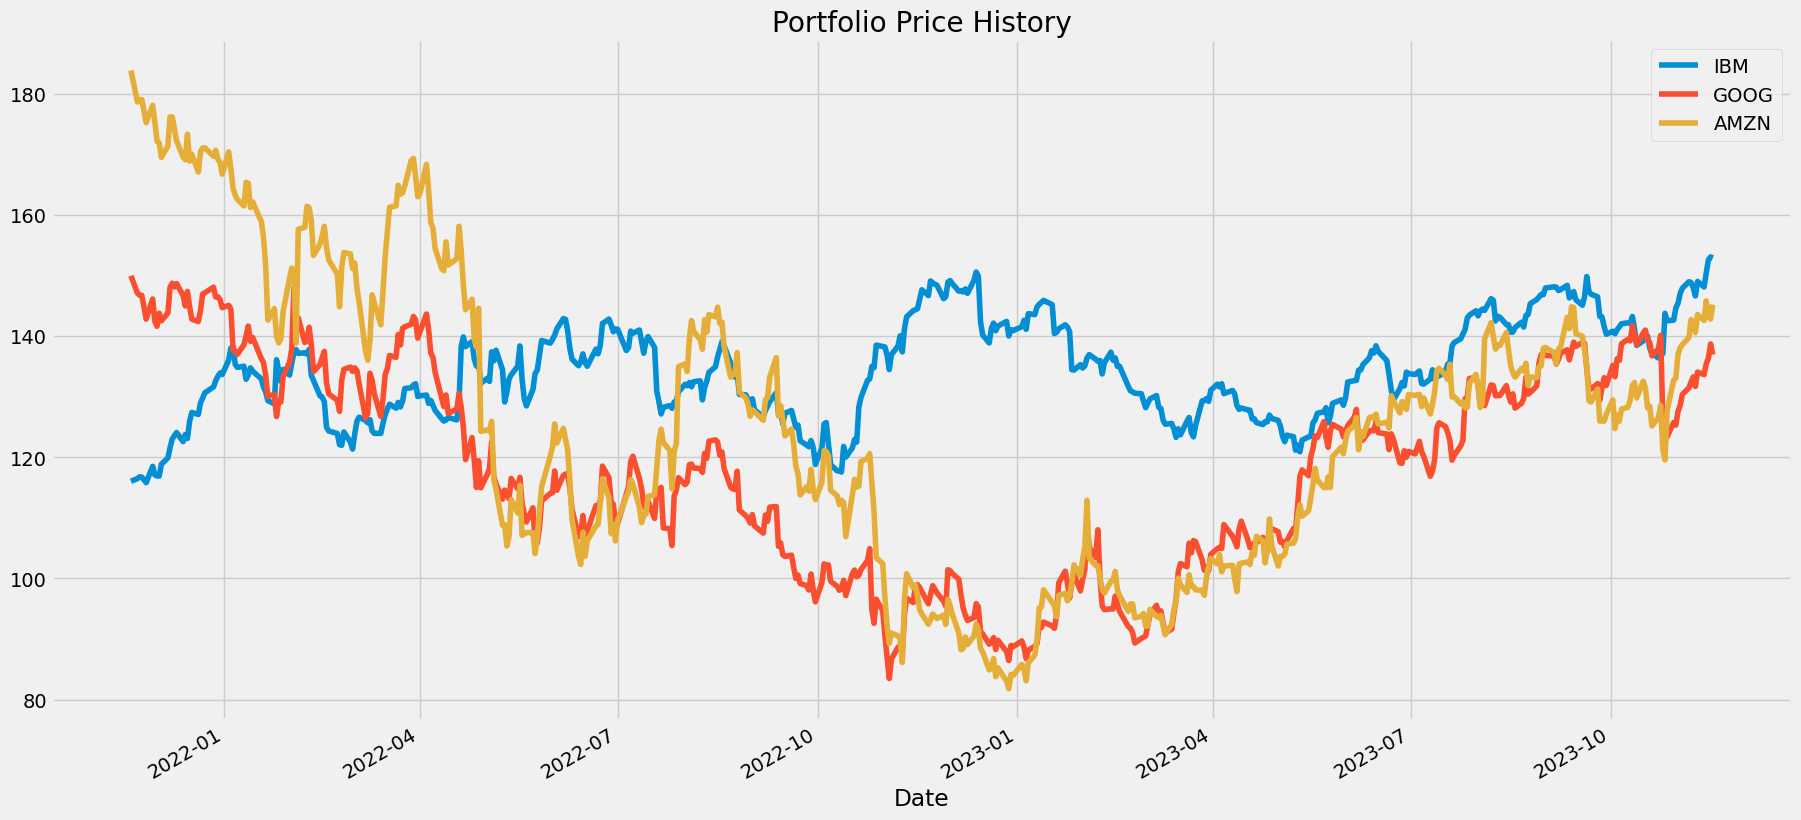

In [11]:
title = 'Portfolio Price History'
stocks = close_df
stocks.plot(title=title, figsize=(20,10))
plt.show()

In [34]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = means
S = cov_matrix
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))

# ef.efficient_return(target_return=0.001, market_neutral=True)
ef.min_volatility()

OrderedDict([('IBM', 0.8192956115681542),
             ('GOOG', 0.156072209967764),
             ('AMZN', 0.0246321784640818)])

In [35]:
ef.portfolio_performance(verbose=True)

Expected annual return: 0.1%
Annual volatility: 1.2%
Sharpe Ratio: -1.56


(0.0005276979765771982, 0.012481709056031085, -1.5600669696762324)